In [34]:
# utilities
import pandas as pd 
import numpy as np
import datetime
from datetime import datetime as dt
from pandas import DataFrame
import warnings
warnings.filterwarnings('ignore')

# plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#model
from statsmodels.tsa.stattools import grangercausalitytests #for causality check
from statsmodels.tsa.stattools import adfuller #for stationarity check
from statsmodels.tsa.seasonal import seasonal_decompose #for the decomposition
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

Importing datasets

In [4]:
co2 = pd.read_csv('co2.csv')

no_raindays = pd.read_csv('rainfall-monthly-number-of-rain-days.csv')
no_raindays.rename(columns={'month':'Date'},inplace=True)

sea_level = pd.read_csv('sea_level.csv')
sea_level.rename(columns = {'Time':'Date'},inplace=True)

humidity = pd.read_csv('relative-humidity-monthly-mean.csv')
humidity.rename(columns = {'month':'Date'},inplace=True)

rainfall = pd.read_csv('rainfall-monthly-total.csv')
rainfall.rename(columns = {'month':'Date'},inplace=True)

temperature = pd.read_csv('surface-air-temperature-monthly-mean.csv')
temperature.rename(columns = {'month':'Date'},inplace=True)

anomaly_temperature = pd.read_csv('anomalies_temperature.csv')

Append new data to: co2, sea_level,anomaly_temperature in order to have data until the 2021.

First thing is to create a new list of dates then create the values of the measurement according to the values in the dataframe.

Change datatype of the column with the date into the datetime format 'YYYY-mm'

In [5]:
co2['Date'] = pd.to_datetime(co2['Date'], format = '%Y-%m')
co2['Date'] = co2['Date'].dt.strftime('%Y-%m')

sea_level['Date'] = pd.to_datetime(sea_level['Date'], format = '%Y-%m')
sea_level['Date'] = sea_level['Date'].dt.strftime('%Y-%m')

humidity['Date'] = pd.to_datetime(humidity['Date'], format = '%Y-%m')
humidity['Date'] = humidity['Date'].dt.strftime('%Y-%m')

rainfall['Date'] = pd.to_datetime(humidity['Date'], format = '%Y-%m')
rainfall['Date'] = rainfall['Date'].dt.strftime('%Y-%m')

temperature['Date'] = pd.to_datetime(temperature['Date'], format = '%Y-%m')
temperature['Date'] = temperature['Date'].dt.strftime('%Y-%m')

anomaly_temperature['Date'] = pd.to_datetime(anomaly_temperature['Date'], format = '%Y-%m')
anomaly_temperature['Date'] = anomaly_temperature['Date'].dt.strftime('%Y-%m')

Now that the dataframes are modified and the cols have the same name and format, i can merge them on the Date and build a unique dataframe.

In [6]:
climate_change = no_raindays.merge(rainfall,on='Date').merge(humidity,on='Date').merge(temperature,on='Date').merge(co2,on='Date').merge(sea_level,on='Date').merge(anomaly_temperature,on='Date')
climate_change.tail()

,Date,no_of_rainy_days,total_rainfall,relative_humidity,surface_temp,co2,GMSL(Global Mean Sea Level),Anomalies_Land_Ocean_Temperature
473,2021-06,20,93.4,77.8,28.5,427.2,13.5,2.59
474,2021-07,12,195.8,76.5,28.6,428.0,13.5,2.62
475,2021-08,24,293.6,80.4,27.6,428.8,13.6,2.65
476,2021-09,14,205.4,77.3,28.3,429.6,13.6,2.68
477,2021-10,14,177.0,78.3,28.5,430.4,13.7,2.71


In [7]:
# change the column values from percentage to decimal 
climate_change['relative_humidity'] = climate_change['relative_humidity'].apply(lambda x: x / 100)
#save the dataframe to csv
climate_change.to_csv('climate_change.csv',index=False)

In [27]:
climate_change = pd.read_csv('climate_change.csv')

In [25]:
#check there are no missing values
climate_change.isna().sum()

Date                                0
no_of_rainy_days                    0
total_rainfall                      0
relative_humidity                   0
surface_temp                        0
co2                                 0
GMSL(Global Mean Sea Level)         0
Anomalies_Land_Ocean_Temperature    0
dtype: int64

DATA VISUALIZATION

In [9]:
def correlation(data : pd.core.frame.DataFrame):
    corr_matrix = data.corr()
    mask = np.zeros_like(corr_matrix) #to plot only a half matrix
    mask[np.triu_indices_from(mask)] = True #to generate a mask for the upper triangle
    sns.heatmap(corr_matrix, mask=mask, square=True,cmap="PuOr_r")
    return

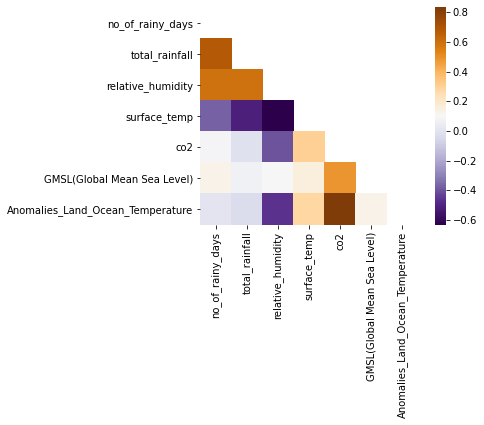

In [10]:
correlation(climate_change)

In [ ]:
values = ['co2','no_of_rainy_days','GMSL(Global Mean Sea Level)','relative_humidity','total_rainfall',
            'surface_temp','Anomalies_Land_Ocean_Temperature']

Autocorrelation

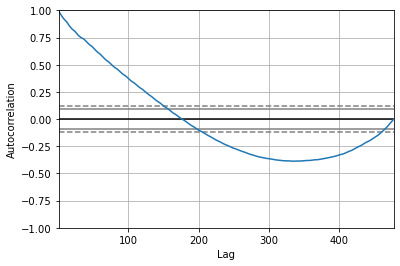

In [11]:
pd.plotting.autocorrelation_plot(climate_change['co2'])
plt.show()
# from this plot we can see that there is a positive correlation with the first 100-to-180 lags that is perhaps 
# significant for the the first 150 lags.

# Hence a good starting point for the AR parametere for co2 could be 100.

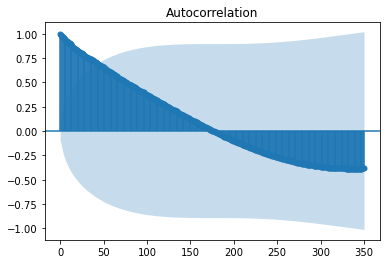

In [12]:
plot_acf(climate_change['co2'], lags=350)
plt.show()

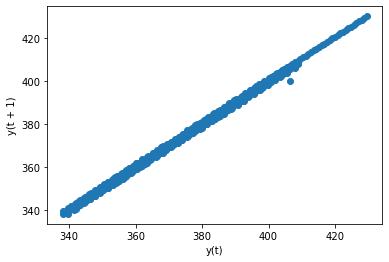

In [13]:
pd.plotting.lag_plot(climate_change['co2'])
plt.show()

Partial autocorrelation

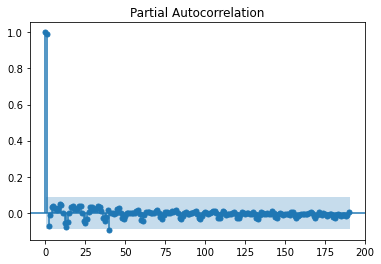

In [14]:
plot_pacf(climate_change['co2'], lags=190)
plt.show()

**ARIMA** stands for:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations;

- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationar;

- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations;

A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.

- d: The number of times that the raw observations are differenced, also called the degree of differencing.

- q: The size of the moving average window, also called the order of moving average.


Time series decomposition - do it for all the variables - 

In [ ]:
# # Multiplicative Decomposition 
# climate_change['co2'].index = pd.to_datetime(climate_change['co2'].index) 
# decomp_mul = seasonal_decompose(climate_change['co2'], model='multiplicative', extrapolate_trend='freq', period=12)
# decomp_mul.plot()
# plt.show()

# # Additive Decomposition
# decomp_add = seasonal_decompose(climate_change['co2'], model='additive', extrapolate_trend='freq', period=12)
# decomp_add.plot()
# plt.show()

Split into train-test and perform forecasting for the co2 data

C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  warnings.warn('No frequency information was'
C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  warnings.warn('No frequency information was'
C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  warnings.warn('No frequency information was'
C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


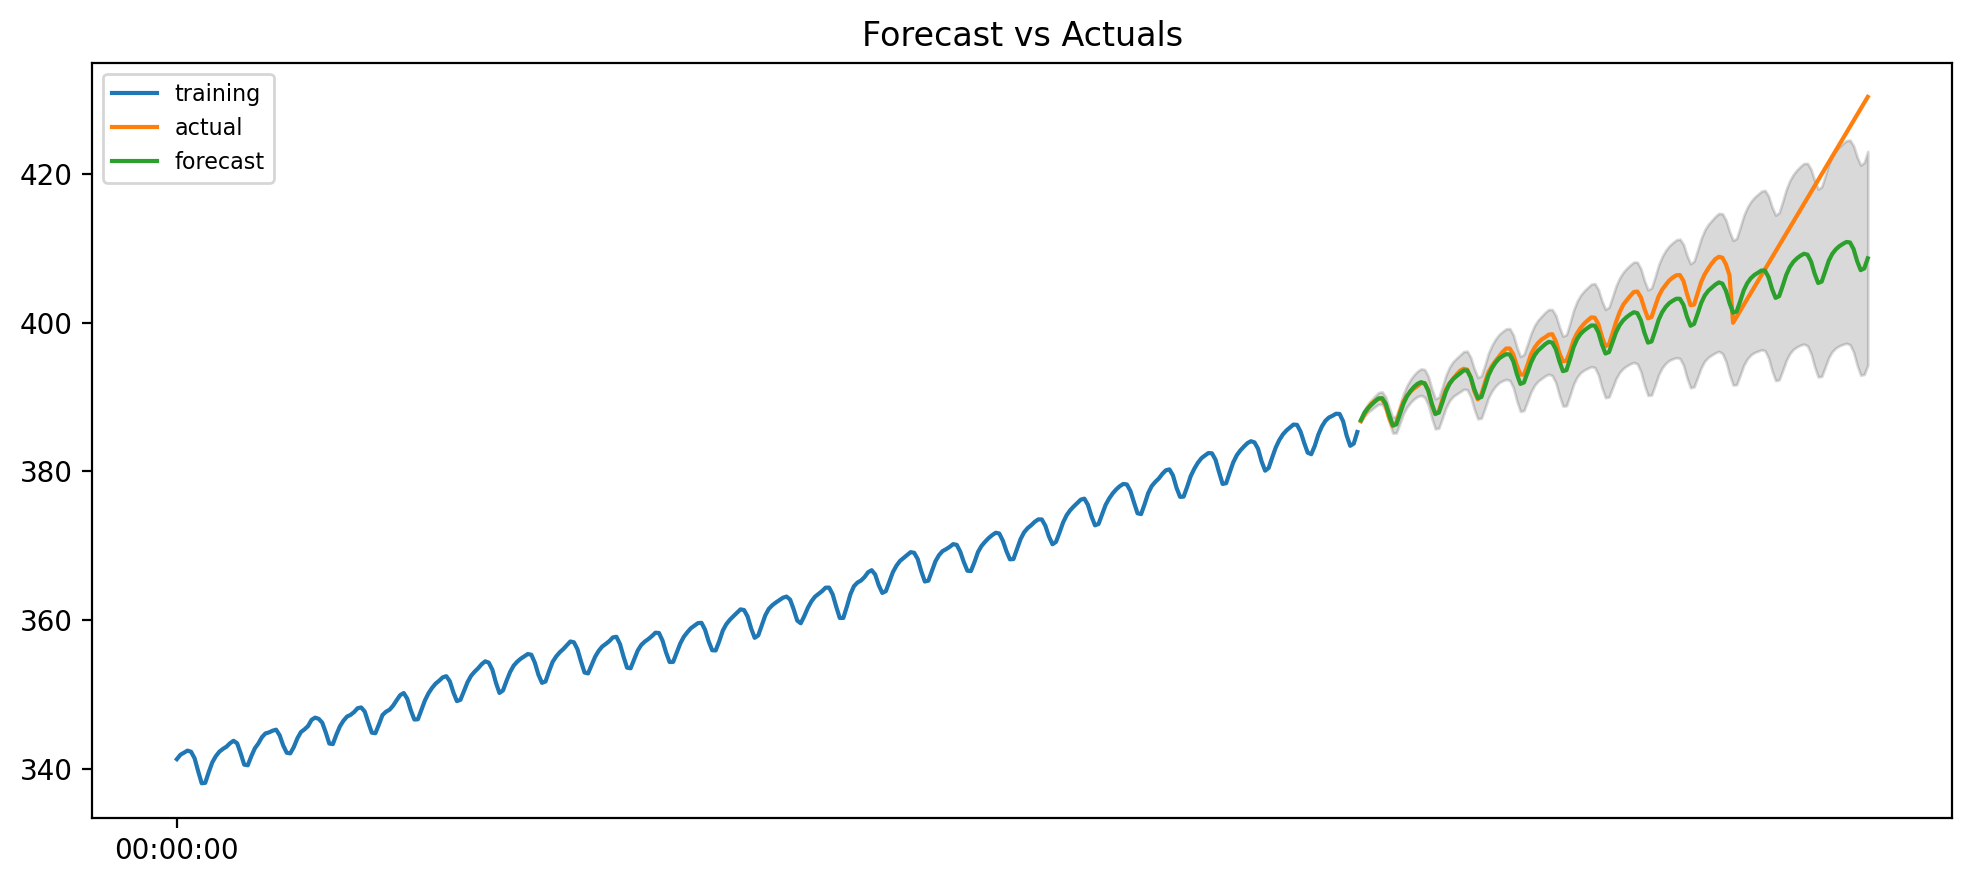

In [17]:
train = climate_change['co2'][:int(np.floor((len(climate_change)/100)*70))] #70% train
test = climate_change['co2'][int(np.floor((len(climate_change)/100)*70)):] #30% train

model = ARIMA(train, order=(80, 2, 1))  
fitted = model.fit()  

fc = fitted.get_forecast(len(climate_change['co2'][int(np.floor((len(climate_change)/100)*70)):]))  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## VARIMA (Vector Arima for multivariate time series forecasting)

Steps:

 1) Causality investigation
 2) Test for stationary
 3) Model 
 4) Prediction
 4) Evaluation


In [33]:
''' 1. CAUSALITY INVESTIGATION 
The Granger Causality Test is used to investigate causality of data: check if a particular variable comes before 
another in the time series.
The Null Hypothesis of the Granger Causality Test is that lagged x-values do not explain the variation in y
(so the x does not cause y).
The critical value used is 5% and if the p-value of a pair of variables is smaller than the significance level, 
then the Null Hypothesis (that the coefficients of the corresponding past values is zero, that is, the X does not 
cause Y) can be rejected.
In the output the rows are the response variable and the columns are the predictors
'''

# variables=climate_change.columns  
# matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
# for col in matrix.columns:
#     for row in matrix.index:
#         test_result = grangercausalitytests(climate_change[[row, col]], maxlag=30, verbose=False)            
#         p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(30)]            
#         min_p_value = np.min(p_values)
#         matrix.loc[row, col] = min_p_value
# matrix.columns = [var + '_x' for var in variables]
# matrix.index = [var + '_y' for var in variables]
# pd.DataFrame(matrix)

maxlag=15
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables) #create the df for the results
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False) #perform the test
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#climate_change.set_index('Date',inplace=True)
climate_change = pd.read_csv('climate_change.csv', index_col='Date')
grangers_causation_matrix(climate_change, variables = climate_change.columns)   

,no_of_rainy_days_x,total_rainfall_x,relative_humidity_x,surface_temp_x,co2_x,GMSL(Global Mean Sea Level)_x,Anomalies_Land_Ocean_Temperature_x
no_of_rainy_days_y,1.0000,0.0024,0.0000,0.0000,0.0000,0.0317,0.0053
total_rainfall_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.1896,0.1522
relative_humidity_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.3026,0.0000
surface_temp_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.3210,0.0000
co2_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0544,0.0000
GMSL(Global Mean Sea Level)_y,0.0227,0.0179,0.0031,0.0750,0.3634,1.0000,0.0566
Anomalies_Land_Ocean_Temperature_y,0.0057,0.0106,0.0007,0.0001,0.0007,0.0166,1.0000


Let's analyze the result obtained. For most of the variables, since the p-values are < 0.05, i can reject the null hypothesis and use them for the VARIMA model. 

But for some variables i can't reject the null hypothesis, in fact the p-values for:
- (GMSL_x,total_rainfall_y) - (GMSL_x,relative_humidity_y) - (GMSL_x,surface_temp_y) 

- (Anomalies_Land_Ocean_Temperature_x,total_rainfall_y)

- (co2_x,GMSL(Global Mean Sea Level)_y)

are bigger than 0.05. That means that the **GMSL doesn't cause the total rainfall, the relative humidity and the surface temperature**, as well as the **Anomalies_Land_Ocean_Temperature doesn't cause the total rainfall** and the **co2 doesn't cause the mean sea level**. 

*As it can be notice, this analysis makes sense since - for example - it's reasonable that the total rainfall causes the surface temperature, the humidity and the anomalies in the temperature; just as it would have made less sense if the co2 emissions causes the Sea Level - but for sure it causes the surface temperature.*

In the end I can state that, exept for the GMSL and the others two pairs listed before, the other variables are interchangeably causing each other. 

For now on i will not include the GMSL in the model.

In [98]:
#CLIMATE DATA WITHOUT GMSL
data_cc = climate_change.drop(['GMSL(Global Mean Sea Level)'],axis=1)

In [78]:
''' 2. STATIONARITY TEST
VectorARMA requires time series to be stationary(mean and variance does not change over time), to test it
i use the ADF Test.
'''

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary")

for name, column in data_cc.iteritems():
    adfuller_test(column, name=column.name)


 no_of_rainy_days : P-Value = 0.0 => Stationary
 total_rainfall : P-Value = 0.0 => Stationary
 relative_humidity : P-Value = 0.233 => Non-stationary
 surface_temp : P-Value = 0.0 => Stationary
 co2 : P-Value = 0.999 => Non-stationary
 Anomalies_Land_Ocean_Temperature : P-Value = 0.999 => Non-stationary


In [79]:
'''' Train-test splitting'''
train = data_cc[:int(np.floor((len(data_cc)/100)*70))] #70% train
test = data_cc[int(np.floor((len(data_cc)/100)*70)):] #30% train

In [80]:
'''
Since for the relative_humidity,co2 and Anomalies_Land_Ocean_Temperature the test fails, 
i need to make the data stationary (eliminating the trend and seasonality by differencing.
Differencing reduces the length of the series by 1 and since all the time series has to be of the same length, 
i apply the diff() method to all the series.
'''
data_differenced = train.diff().dropna() #diffence the train data
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)


 no_of_rainy_days : P-Value = 0.0 => Stationary
 total_rainfall : P-Value = 0.0 => Stationary
 relative_humidity : P-Value = 0.0 => Stationary
 surface_temp : P-Value = 0.0 => Stationary
 co2 : P-Value = 0.013 => Stationary
 Anomalies_Land_Ocean_Temperature : P-Value = 0.0 => Stationary


So after differenciating i made all the data stationary and also since degree of differencing is **1** it could be used as value of **d** in the model building.

-------------------------------------------------------------------------------------------------

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/


In [81]:
# To find the optimal values of p I will perform the model.select_order() method that highlight
# with a * the lowest AIC value.
model = VAR(data_differenced)
x = model.select_order(maxlags=18)
x.summary()

,AIC,BIC,FPE,HQIC
0,-1.127,-1.055,0.3241,-1.098
1,-2.887,-2.386,0.05576,-2.687
2,-4.481,-3.552,0.01132,-4.110
3,-5.741,-4.383,0.003214,-5.199
4,-6.392,-4.605*,0.001679,-5.678
5,-6.613,-4.397,0.001348,-5.728*
6,-6.728,-4.083,0.001205,-5.671
7,-6.864,-3.790,0.001056,-5.636
8,-7.051,-3.549,0.0008796,-5.652
9,-7.042,-3.110,0.0008938,-5.471


As the value of the P increases model becomes more complex and the AIC penalizes the complex model.

As can be seen from the result, the AIC begins to drop as i fit the more complex model (around 11) but, after a certain amount of time AIC begins to increase again (from 13). It’s because AIC is punishing these models for being too complex.

The VAR(p=12) returns the lowest score and after that again AIC starts increasing, hence i will build the VAR model of order 12. 

In [82]:
# train the VAR model of selected order (p=12)
p=12
model_fitted = model.fit(p)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, Dec, 2021
Time:                     11:14:43
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -2.10671
Nobs:                     321.000    HQIC:                  -5.19809
Log likelihood:          -1130.80    FPE:                0.000743433
AIC:                     -7.25279    Det(Omega_mle):     0.000217418
--------------------------------------------------------------------
Results for equation no_of_rainy_days
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                       -1.761764         0.801622           -2.198           0.028
L1.no_of_rainy_days                         -0.871128        

PREDICTION

In order to forecast, the VAR model expects up to the lag order number of observations from the past data since the terms in the VAR model are essentially the lags of the various time series in the dataset.

In [84]:
lag = model_fitted.k_ar #12

# input data for forecasting
lagged_Values = data_differenced.values[-lag:] # specify the 'initial value' for the forecast

# Forecast
n_obs = 12 #number of observations to forecast - in this case one year (12 months)
pred = model_fitted.forecast(y=data_differenced.values, steps=len(train))  #pred = model_fitted.forecast(y=lagged_Values, steps=n_obs) 
df_forecast = pd.DataFrame(pred, columns=data_differenced.columns + '_d')#df_forecast = pd.DataFrame(pred, index=climate_change.index[-n_obs:], columns=climate_change.columns + '_d')
df_forecast


#idx = pd.date_range('2021-01-01', periods=12, freq='MS')
#df_forecast=pd.DataFrame(data=pred, index=idx, columns=cols)

,no_of_rainy_days_d,total_rainfall_d,relative_humidity_d,surface_temp_d,co2_d,Anomalies_Land_Ocean_Temperature_d
0,9.184813,208.947152,0.038672,-1.030184,1.666874,0.020048
1,-4.251129,15.351364,-0.017753,-0.081470,1.059470,-0.008988
2,-6.477882,-81.726851,-0.018058,-0.085592,0.693908,-0.038867
3,-3.199163,-162.765328,-0.016053,0.534186,0.412852,0.121571
4,2.606243,47.193795,0.021318,0.289544,0.274664,-0.001338
...,...,...,...,...,...,...
329,1.575997,-7.979689,-0.000052,0.579045,0.015148,-0.027469
330,1.777375,20.666748,0.001868,0.178058,-0.457910,-0.034687
331,0.530539,18.051728,-0.001685,-0.202603,-1.155060,-0.020184
332,-0.631939,-0.502689,-0.004493,-0.357684,-1.481133,0.002181


INVERT THE TRANSFORMATION

Notice that the forecasted value is a first-order difference. To get it similar to original data i have to 'roll back' each difference by taking the most recent values of the original series’ training data and adding it to a cumulative sum of forecasted values.


In [116]:
#create a new dataframe with the prediction
df_prediction = df_forecast.copy()

df_prediction['no_of_rainy_days_P'] = data_cc['no_of_rainy_days'].iloc[-1] + df_forecast['no_of_rainy_days_d'].cumsum()
df_prediction['total_rainfall_P'] = data_cc['total_rainfall'].iloc[-1] + df_forecast['total_rainfall_d'].cumsum()
df_prediction['relative_humidity_P'] = data_cc['relative_humidity'].iloc[-1] + df_forecast['relative_humidity_d'].cumsum()
df_prediction['surface_temp_P'] = data_cc['surface_temp'].iloc[-1] + df_forecast['surface_temp_d'].cumsum()
df_prediction['co2_P'] = data_cc['co2'].iloc[-1] + df_forecast['co2_d'].cumsum()
df_prediction['Anomalies_Land_Ocean_Temperature_P'] = data_cc['Anomalies_Land_Ocean_Temperature'].iloc[-1] + df_forecast['Anomalies_Land_Ocean_Temperature_d'].cumsum()

df_prediction.head()

,no_of_rainy_days_d,total_rainfall_d,relative_humidity_d,surface_temp_d,co2_d,Anomalies_Land_Ocean_Temperature_d,no_of_rainy_days_P,total_rainfall_P,relative_humidity_P,surface_temp_P,co2_P,Anomalies_Land_Ocean_Temperature_P
0,9.184813,208.947152,0.038672,-1.030184,1.666874,0.020048,23.184813,385.947152,0.821672,27.469816,432.066874,2.730048
1,-4.251129,15.351364,-0.017753,-0.081470,1.059470,-0.008988,18.933685,401.298516,0.803919,27.388346,433.126344,2.721061
2,-6.477882,-81.726851,-0.018058,-0.085592,0.693908,-0.038867,12.455803,319.571665,0.785861,27.302753,433.820252,2.682193
3,-3.199163,-162.765328,-0.016053,0.534186,0.412852,0.121571,9.256641,156.806337,0.769808,27.836939,434.233104,2.803764
4,2.606243,47.193795,0.021318,0.289544,0.274664,-0.001338,11.862884,204.000132,0.791126,28.126483,434.507768,2.802426


Plot the result

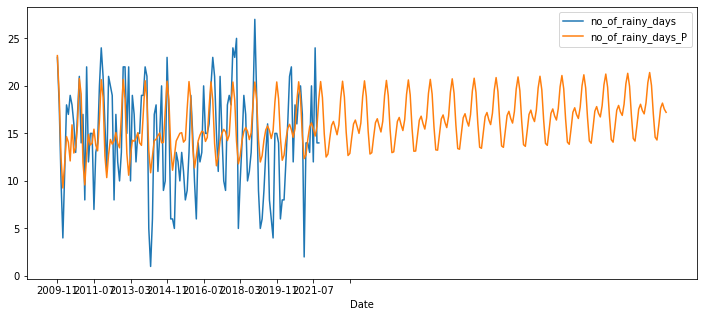

In [128]:
test_or = data_cc[-144:]
test_or['no_of_rainy_days'].plot(figsize=(12,5),legend=True);
df_prediction['no_of_rainy_days_P'].plot(legend=True);

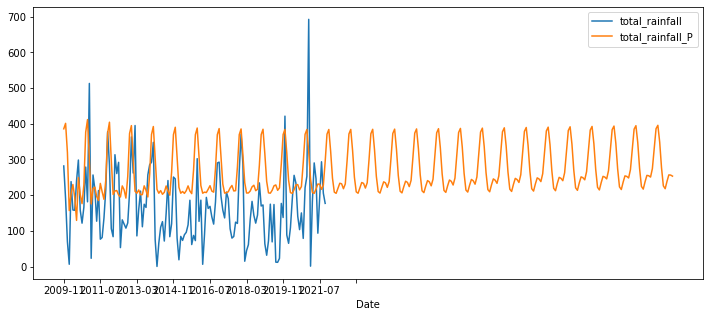

In [129]:
test_or['total_rainfall'].plot(figsize=(12,5),legend=True);
df_prediction['total_rainfall_P'].plot(legend=True);

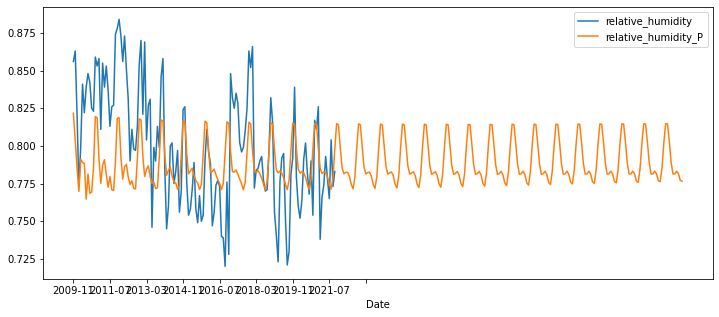

In [132]:
test_or['relative_humidity'].plot(figsize=(12,5),legend=True);
df_prediction['relative_humidity_P'].plot(legend=True);

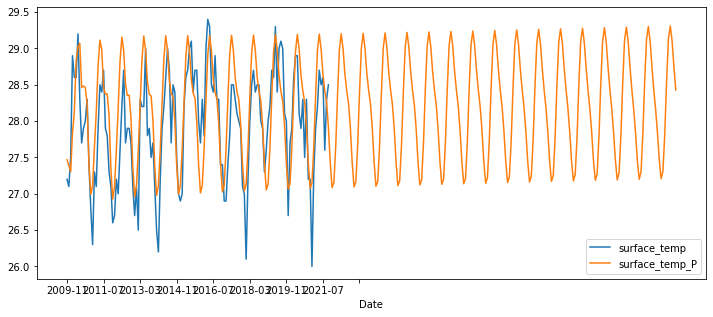

In [131]:
test_or['surface_temp'].plot(figsize=(12,5),legend=True);
df_prediction['surface_temp_P'].plot(legend=True);

Evaluate the forecast

In [135]:
from statsmodels.tsa.stattools import acf
from sklearn import metrics

def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    r2 = metrics.r2_score(actual, forecast)  #R²

    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'rmse':rmse, 'R²':r2, 'minmax':minmax})

def adjust(val, length= 6): 
    return str(val).ljust(length)

In [139]:
print('Forecast Accuracy of: no_of_rainy_days')
accuracy_prod = forecast_accuracy(df_prediction['no_of_rainy_days_P'].values, ['no_of_rainy_days'])

for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: no_of_rainy_days


ValueError: operands could not be broadcast together with shapes (334,) (333,) 